# Practical Machine Learning for Physicists
## Week 4 Exercise - Part 2


For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



#### Practicalities
You should use this notebook for your work and upload it to both Moodle and CoCalc. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)



In [5]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense


#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2023-02-13 17:35:55.129663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


In [6]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator


In [7]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


## Task 1

In [158]:
#creating the model
model=keras.Sequential()
#4 kernels size=5x5 and a batchnormalization ending up with an average pooling reducing dimensionality to 9x9
model.add(keras.layers.Conv2D(4,5,input_shape=(None,None,1),activation="relu",
                              padding='same'))#no reduction in dimensionality
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))

#second down sampling + a dropout to reduce overfitting
model.add(keras.layers.Conv2D(4,5,activation="relu",
                              padding='same'))#no reduction in dimensionality
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))
model.add(keras.layers.Dropout(0.03))

## SIZE OF OUTPUT FROM THIS LAYER IS (3,3)

#Bottleneck
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(1,3,activation='relu',padding='same'))
model.add(keras.layers.BatchNormalization())

# UP SAMPLING TO RISE DIMENSIONALITY

#Up sampling to (9,9)
model.add(keras.layers.UpSampling2D(size=(3,3)))
model.add(keras.layers.Conv2D(4,5,activation='relu',padding='same'))
model.add(keras.layers.Conv2D(4,5,activation="relu",padding='same'))#no reduction in dimensionality
#model.add(keras.layers.BatchNormalization())


#Up sampling (27,27)
model.add(keras.layers.UpSampling2D(size=(3,3)))
model.add(keras.layers.Conv2D(4,5,activation='relu',padding='same'))
model.add(keras.layers.Dropout(0.03))
model.add(keras.layers.BatchNormalization())

#Last convulational layer
model.add(keras.layers.Conv2D(1,5,activation='sigmoid',padding='same'))

#mean square error loss
model.compile(loss='mean_squared_error',
              optimizer='adam')

In [159]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_134 (Conv2D)         (None, None, None, 4)     104       
                                                                 
 batch_normalization_120 (Ba  (None, None, None, 4)    16        
 tchNormalization)                                               
                                                                 
 average_pooling2d_56 (Avera  (None, None, None, 4)    0         
 gePooling2D)                                                    
                                                                 
 conv2d_135 (Conv2D)         (None, None, None, 4)     404       
                                                                 
 batch_normalization_121 (Ba  (None, None, None, 4)    16        
 tchNormalization)                                               
                                                     

In [160]:
steps=600
cost,y_target=generate_and_train(model,circle_generator,img_size=27,batchsize=50,steps=steps)

In [161]:
print_layers(model,y_target)

Layer 0: 2916 neurons /  (50, 27, 27, 4)
Layer 1: 2916 neurons /  (50, 27, 27, 4)
Layer 2: 324 neurons /  (50, 9, 9, 4)
Layer 3: 324 neurons /  (50, 9, 9, 4)
Layer 4: 324 neurons /  (50, 9, 9, 4)
Layer 5: 36 neurons /  (50, 3, 3, 4)
Layer 6: 36 neurons /  (50, 3, 3, 4)
Layer 7: 36 neurons /  (50, 3, 3, 4)
Layer 8: 9 neurons /  (50, 3, 3, 1)
Layer 9: 9 neurons /  (50, 3, 3, 1)
Layer 10: 81 neurons /  (50, 9, 9, 1)
Layer 11: 324 neurons /  (50, 9, 9, 4)
Layer 12: 324 neurons /  (50, 9, 9, 4)
Layer 13: 2916 neurons /  (50, 27, 27, 4)
Layer 14: 2916 neurons /  (50, 27, 27, 4)
Layer 15: 2916 neurons /  (50, 27, 27, 4)
Layer 16: 2916 neurons /  (50, 27, 27, 4)
Layer 17: 729 neurons /  (50, 27, 27, 1)


Text(0.5, 1.0, 'cost function of model over steps')

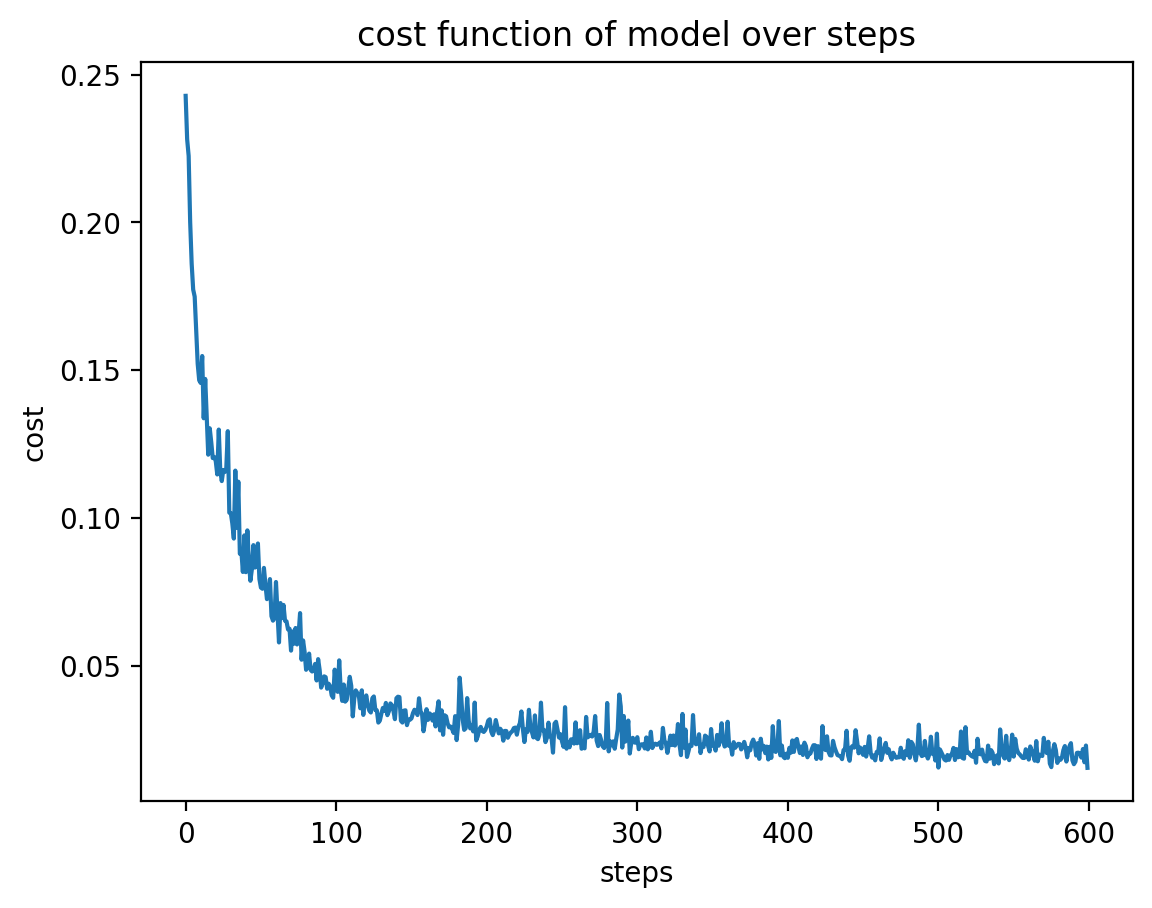

In [162]:
fig,ax=plt.subplots()
ax.plot(cost)
ax.set_xlabel('steps')
ax.set_ylabel('cost')
ax.set_title('cost function of model over steps')

In [205]:
print('finally achieving a cost function of ',cost[-1])

finally achieving a cost function of  0.015370255336165428


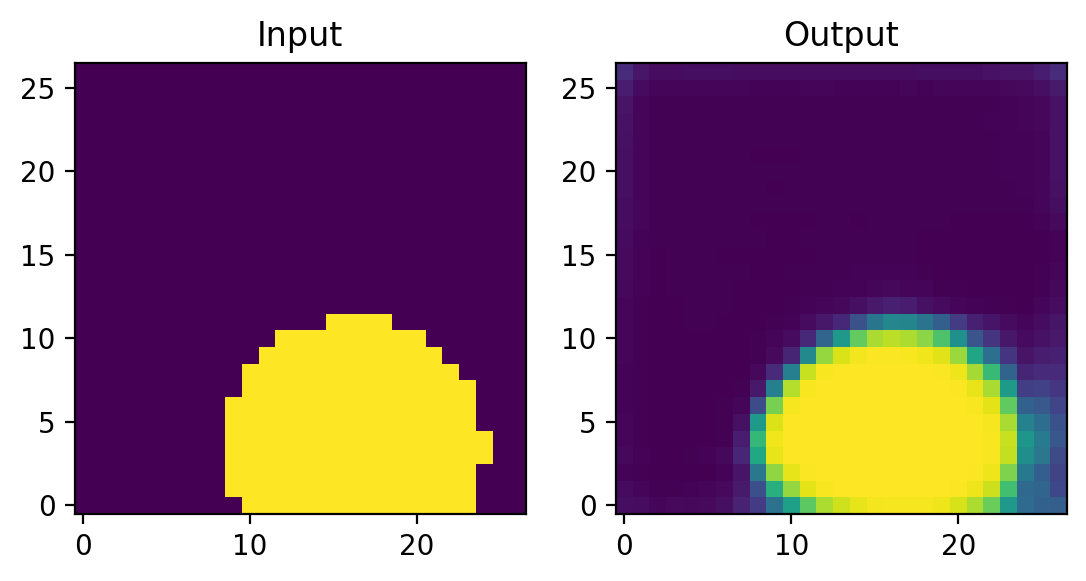

In [168]:
plot_test_image(model,circle_generator,27)

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



In [335]:
#creating the model
model2=keras.Sequential()
#4 kernels size=5x5 and a batchnormalization ending up with an average pooling reducing dimensionality to 9x9
model2.add(keras.layers.Conv2D(4,5,input_shape=(None,None,1),activation="relu",
                              padding='same'))#no reduction in dimensionality
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))

#second down sampling + a dropout to reduce overfitting
model2.add(keras.layers.Conv2D(4,5,activation="relu",padding='same'))#no reduction in dimensionality
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))
model2.add(keras.layers.BatchNormalization())


## SIZE OF OUTPUT FROM THIS LAYER IS (3,3)

#Bottleneck
model2.add(keras.layers.Conv2D(3,3,activation='relu',padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))

# UP SAMPLING TO RISE DIMENSIONALITY


#Up sampling to (3,3)
model2.add(keras.layers.UpSampling2D(size=(3,3)))
model2.add(keras.layers.Conv2D(4,5,activation='relu',padding='same'))
model2.add(keras.layers.BatchNormalization())

#Up sampling to (9,9)
model2.add(keras.layers.UpSampling2D(size=(3,3)))
model2.add(keras.layers.Conv2D(4,5,activation='relu',padding='same'))


#Up sampling (27,27)
model2.add(keras.layers.UpSampling2D(size=(3,3)))
model2.add(keras.layers.Conv2D(4,5,activation='sigmoid',padding='same'))


#Last convulational layer
model2.add(keras.layers.Conv2D(1,5,activation='sigmoid',padding='same'))
#mean square error loss
model2.compile(loss='mean_squared_error',
              optimizer='nadam')

In [336]:
model2.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_319 (Conv2D)         (None, None, None, 4)     104       
                                                                 
 batch_normalization_240 (Ba  (None, None, None, 4)    16        
 tchNormalization)                                               
                                                                 
 average_pooling2d_133 (Aver  (None, None, None, 4)    0         
 agePooling2D)                                                   
                                                                 
 conv2d_320 (Conv2D)         (None, None, None, 4)     404       
                                                                 
 average_pooling2d_134 (Aver  (None, None, None, 4)    0         
 agePooling2D)                                                   
                                                     

In [337]:
steps=700
cost2,y_target2=generate_and_train(model2,circle_generator,img_size=27,batchsize=50,steps=steps)

In [338]:
print_layers(model2,y_target2)

Layer 0: 2916 neurons /  (50, 27, 27, 4)
Layer 1: 2916 neurons /  (50, 27, 27, 4)
Layer 2: 324 neurons /  (50, 9, 9, 4)
Layer 3: 324 neurons /  (50, 9, 9, 4)
Layer 4: 36 neurons /  (50, 3, 3, 4)
Layer 5: 36 neurons /  (50, 3, 3, 4)
Layer 6: 27 neurons /  (50, 3, 3, 3)
Layer 7: 3 neurons /  (50, 1, 1, 3)
Layer 8: 27 neurons /  (50, 3, 3, 3)
Layer 9: 36 neurons /  (50, 3, 3, 4)
Layer 10: 36 neurons /  (50, 3, 3, 4)
Layer 11: 324 neurons /  (50, 9, 9, 4)
Layer 12: 324 neurons /  (50, 9, 9, 4)
Layer 13: 2916 neurons /  (50, 27, 27, 4)
Layer 14: 2916 neurons /  (50, 27, 27, 4)
Layer 15: 729 neurons /  (50, 27, 27, 1)


Text(0.5, 1.0, 'cost function of model over steps')

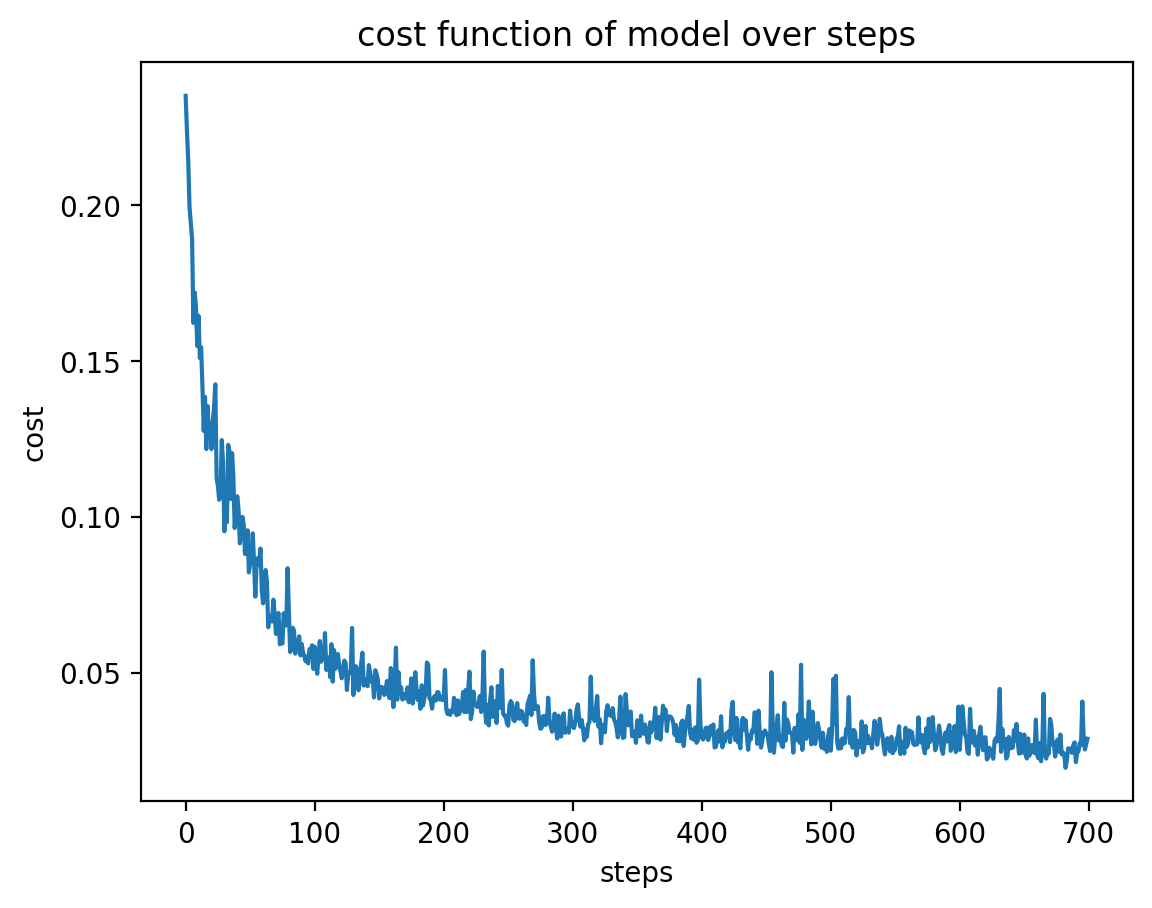

In [339]:
fig,ax=plt.subplots()
ax.plot(cost2)
ax.set_xlabel('steps')
ax.set_ylabel('cost')
ax.set_title('cost function of model over steps')

In [340]:
print('finally achieving a cost function of ',cost2[-1])

finally achieving a cost function of  0.02877676486968994


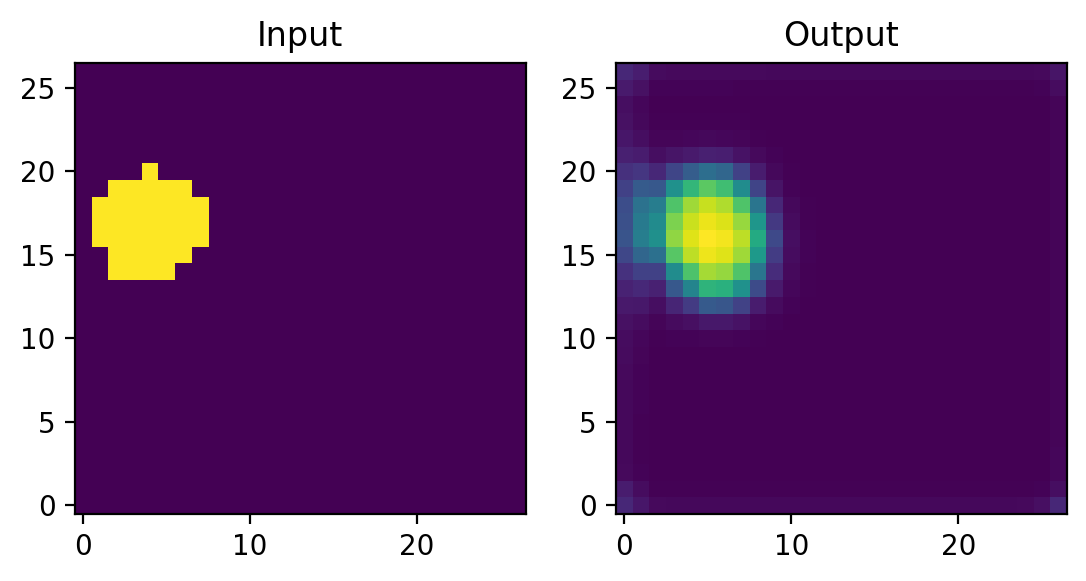

In [342]:
plot_test_image(model0,circle_generator,27)

## Comments
- Overall the goals were achieved succesfully first the model with 9 neurons in bottleneck performed well and efficently with a cost function of 0.015 and a pretty good result with plot_images.
Giving a better result wiht the addition of drop layers and averagepooling instead of maxpooling.
- For the task 2 i decided that the cost function could be a bit higher and I end up with a cost function of 0.026 which was a decent result and a good plot_images result too. It is importatn to notice that adam optimizer was replace by nadam which gave a better result also other optimizers were tested and nadam gave the best cost function.